In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_log_error

from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split

In [2]:
df = pd.read_csv('train.csv', index_col='id')
# df.rename(columns={'timestamp' : 'date', 'price_doc' : 'price_doc'}, inplace=True)
print('Rows:', df.shape[0], '\nColumns', df.shape[1])

Rows: 30471 
Columns 291


In [3]:
df.head()

,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,...,cafe_count_5000_price_2500,cafe_count_5000_price_4000,cafe_count_5000_price_high,big_church_count_5000,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000,price_doc
id,,,,,,,,,,,,,,,,,,,,,
1,2011-08-20,43,27.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,...,9,4,0,13,22,1,0,52,4,5850000
2,2011-08-23,34,19.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,...,15,3,0,15,29,1,10,66,14,6000000
3,2011-08-27,43,29.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,...,10,3,0,11,27,0,4,67,10,5700000
4,2011-09-01,89,50.0,9.0,NaN,NaN,NaN,NaN,NaN,NaN,...,11,2,1,4,4,0,0,26,3,13100000
5,2011-09-05,77,77.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,...,319,108,17,135,236,2,91,195,14,16331452


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30471 entries, 1 to 30473
Columns: 291 entries, timestamp to price_doc
dtypes: float64(119), int64(156), object(16)
memory usage: 67.9+ MB


In [5]:
train, test = train_test_split(df, test_size=0.2, random_state=42)

In [6]:
X_train = train.drop(['price_doc', 'timestamp'], axis=1)
y_train = train['price_doc']
X_test = test.drop(['price_doc', 'timestamp'], axis=1)
y_test = test['price_doc']

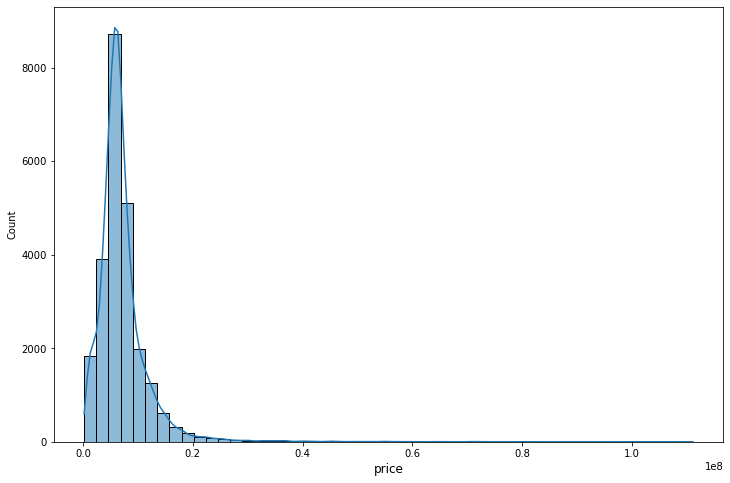

In [7]:
plt.figure(figsize=(12,8))
sns.histplot(train['price_doc'].values, bins=50, kde=True)
plt.xlabel('price', fontsize=12)
plt.show()

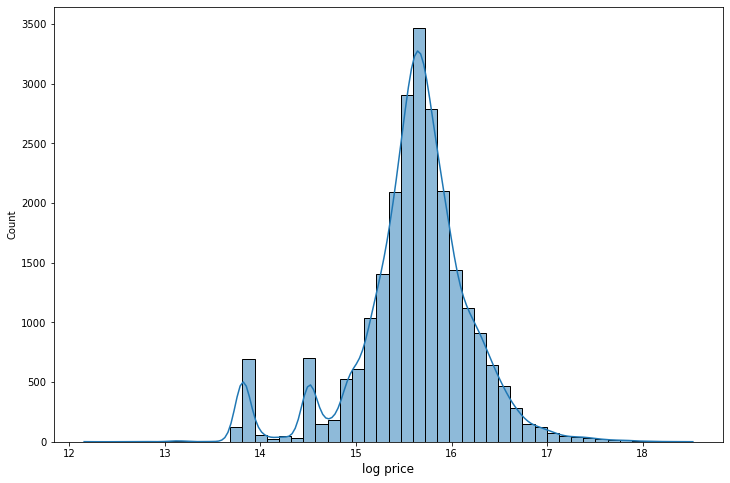

In [8]:
plt.figure(figsize=(12,8))
sns.histplot(np.log(train['price_doc'].values), bins=50, kde=True)
plt.xlabel('log price', fontsize=12)
plt.show()

In [9]:
cat_features = list(X_train.select_dtypes(include=['object']).columns)
df[cat_features]

,product_type,sub_area,culture_objects_top_25,thermal_power_plant_raion,incineration_raion,oil_chemistry_raion,radiation_raion,railroad_terminal_raion,big_market_raion,nuclear_reactor_raion,detention_facility_raion,water_1line,big_road1_1line,railroad_1line,ecology
id,,,,,,,,,,,,,,,
1,Investment,Bibirevo,no,no,no,no,no,no,no,no,no,no,no,no,good
2,Investment,Nagatinskij Zaton,yes,no,no,no,no,no,no,no,no,no,no,no,excellent
3,Investment,Tekstil'shhiki,no,no,no,no,yes,no,no,no,no,no,no,no,poor
4,Investment,Mitino,no,no,no,no,no,no,no,no,no,no,no,no,good
5,Investment,Basmannoe,no,no,no,no,yes,yes,no,no,no,no,no,yes,excellent
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30469,Investment,Otradnoe,no,no,yes,no,yes,no,no,no,no,no,no,no,good
30470,Investment,Tverskoe,yes,no,no,no,yes,yes,no,no,yes,no,no,no,poor
30471,OwnerOccupier,Poselenie Vnukovskoe,no,no,no,no,no,no,no,no,no,no,no,no,no data


In [10]:
df['product_type'].value_counts()

Investment       19448
OwnerOccupier    11023
Name: product_type, dtype: int64

In [11]:
clf = CatBoostRegressor(iterations=100, verbose=0)

In [12]:
clf.fit(X_train, y_train, cat_features=cat_features)

In [13]:
mean_squared_log_error(clf.predict(X_train), y_train)

0.20082116457362686

In [14]:
mean_squared_log_error(clf.predict(X_test), y_test)

0.21802379909033384

In [15]:
def plot_feature_importance(importance, names, model_type, top=None):

#Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    #Create a DataFrame using a Dictionary
    data=pd.DataFrame({'feature_names':feature_names,
                       'feature_importance':feature_importance})
    data.sort_values('feature_importance', ascending=False, inplace=True)
    if top:
        data = data[:top]

    plt.figure(figsize=(12, 10))
    #Plot Searborn bar chart
    sns.barplot(x=data['feature_importance'], y=data['feature_names'])
    #Add chart labels
    plt.title(model_type + ' FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')
    return list(data['feature_names'])

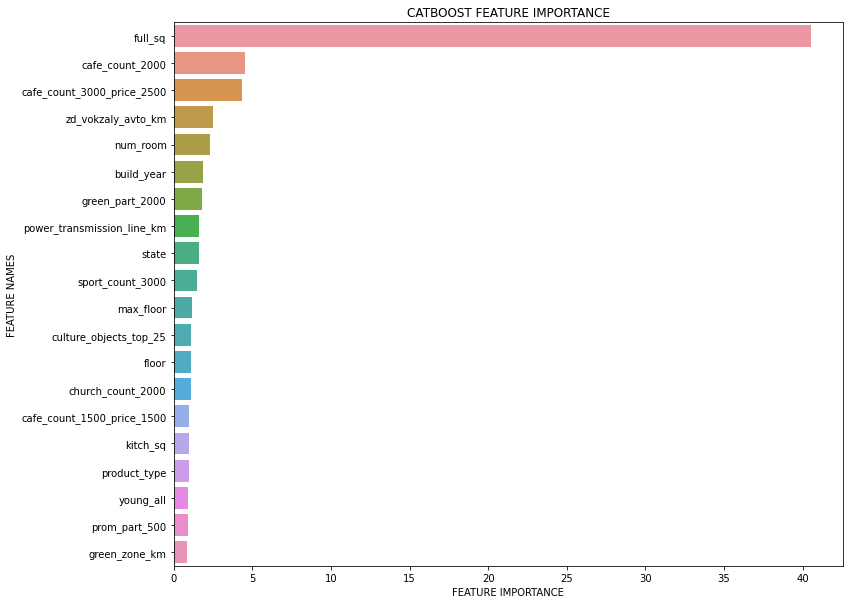

In [16]:
mif = plot_feature_importance(clf.get_feature_importance(), X_test.columns,'CATBOOST', top=20)

<AxesSubplot:>

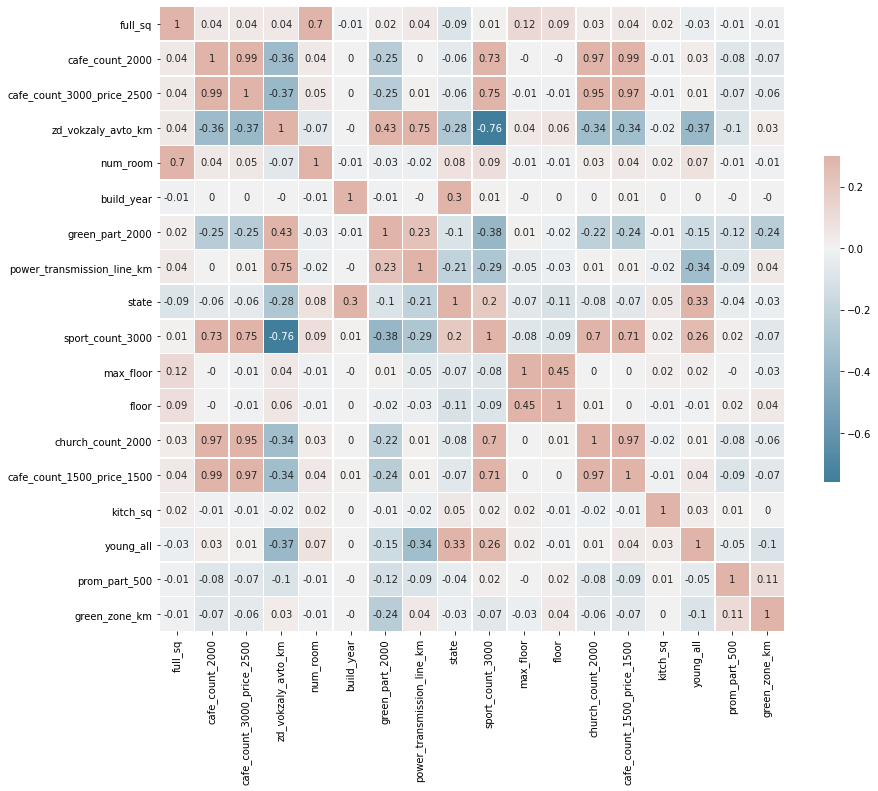

In [17]:
f, ax = plt.subplots(figsize=(14, 12))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(df[mif].corr().apply(lambda x : round(x, 2)), cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)

### Macro date

In [18]:
macro = pd.read_csv('macro.csv')
macro.rename(columns={'timestamp' : 'timestamp'}, inplace=True)
print('Rows:', macro.shape[0], '\nColumns', macro.shape[1])

Rows: 2484 
Columns 100


In [19]:
df_all = pd.merge(df, macro, on='timestamp')
df_all.head()

,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,...,provision_retail_space_modern_sqm,turnover_catering_per_cap,theaters_viewers_per_1000_cap,seats_theather_rfmin_per_100000_cap,museum_visitis_per_100_cap,bandwidth_sports,population_reg_sports_share,students_reg_sports_share,apartment_build,apartment_fund_sqm
0,2011-08-20,43,27.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,...,271.0,6943.0,565.0,0.45356,1240.0,269768.0,22.37,64.12,23587.0,230310.0
1,2011-08-23,34,19.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,...,271.0,6943.0,565.0,0.45356,1240.0,269768.0,22.37,64.12,23587.0,230310.0
2,2011-08-27,43,29.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,...,271.0,6943.0,565.0,0.45356,1240.0,269768.0,22.37,64.12,23587.0,230310.0
3,2011-09-01,89,50.0,9.0,NaN,NaN,NaN,NaN,NaN,NaN,...,271.0,6943.0,565.0,0.45356,1240.0,269768.0,22.37,64.12,23587.0,230310.0
4,2011-09-05,77,77.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,...,271.0,6943.0,565.0,0.45356,1240.0,269768.0,22.37,64.12,23587.0,230310.0


In [20]:
X = df_all.drop(['price_doc', 'timestamp'], axis=1)
y = df_all['price_doc']
cat_features_all = list(X.select_dtypes(include=['object']).columns)

In [21]:
for features in cat_features_all:
    X[features].fillna('Missing', inplace=True)

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [23]:
clf_all = CatBoostRegressor(iterations=100, verbose=0)
clf_all.fit(X_train, y_train, cat_features=cat_features_all)

In [24]:
mean_squared_log_error(clf_all.predict(X_train), y_train)

0.19578706990419253

In [25]:
mean_squared_log_error(clf_all.predict(X_test), y_test)

0.21862811031978013

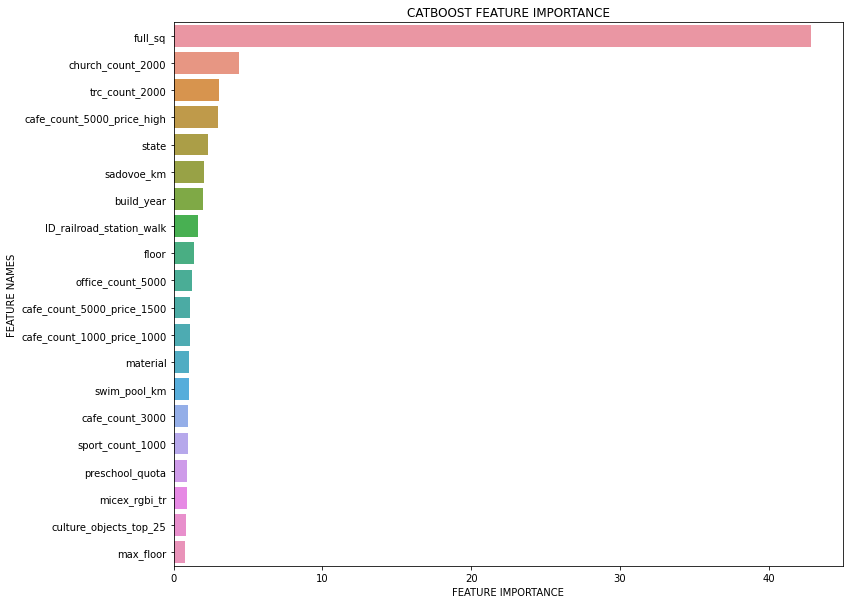

In [26]:
mif = plot_feature_importance(clf_all.get_feature_importance(), X_test.columns,'CATBOOST', top=20)

<AxesSubplot:>

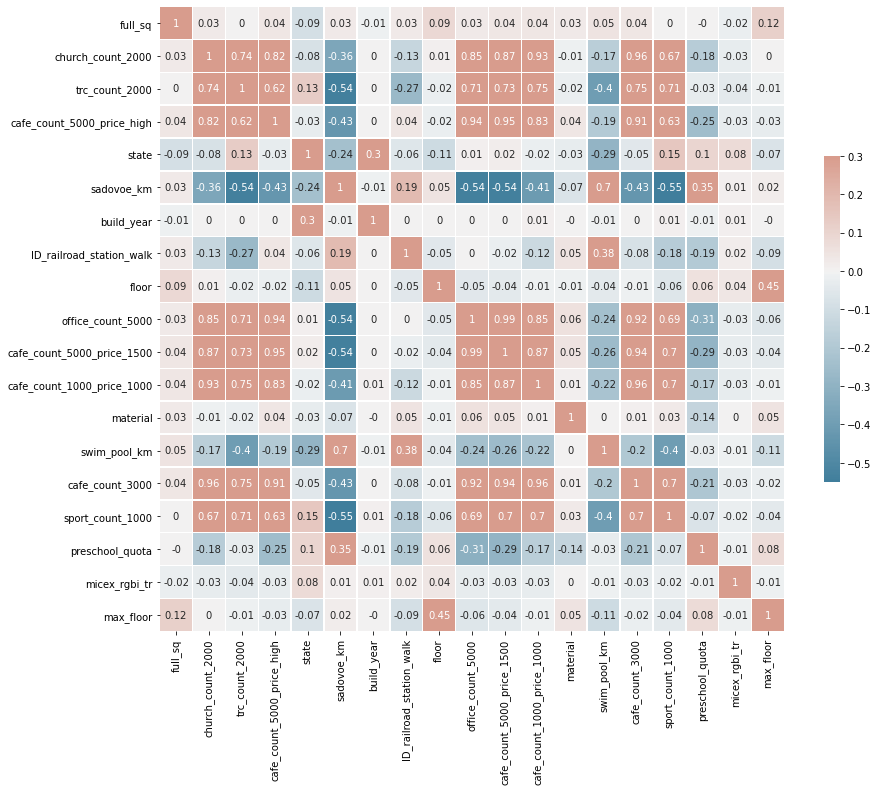

In [27]:
f, ax = plt.subplots(figsize=(14, 12))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(df_all[mif].corr().apply(lambda x : round(x, 2)), cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)

### Для kaggle

In [28]:
clf_all = CatBoostRegressor(iterations=100, verbose=0)
clf_all.fit(X, y, cat_features=cat_features_all)

In [29]:
sub = pd.read_csv('test.csv', index_col='id')
sub.rename(columns={'timestamp' : 'timestamp'}, inplace=True)
sub.head()

,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,...,cafe_count_5000_price_1500,cafe_count_5000_price_2500,cafe_count_5000_price_4000,cafe_count_5000_price_high,big_church_count_5000,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000
id,,,,,,,,,,,,,,,,,,,,,
30474,2015-07-01,39.0,20.7,2,9,1,1998.0,1,8.9,3.0,...,8,0,0,0,1,10,1,0,14,1
30475,2015-07-01,79.2,NaN,8,17,1,0.0,3,1.0,1.0,...,4,1,1,0,2,11,0,1,12,1
30476,2015-07-01,40.5,25.1,3,5,2,1960.0,2,4.8,2.0,...,42,11,4,0,10,21,0,10,71,11
30477,2015-07-01,62.8,36.0,17,17,1,2016.0,2,62.8,3.0,...,1,1,2,0,0,10,0,0,2,0
30478,2015-07-01,40.0,40.0,17,17,1,0.0,1,1.0,1.0,...,5,1,1,0,2,12,0,1,11,1


In [30]:
submis = pd.merge(sub, macro, on='timestamp', right_index=True)
for features in cat_features_all:
    submis[features].fillna('Missing', inplace=True)
del submis['timestamp']
submis.head()

,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,product_type,...,provision_retail_space_modern_sqm,turnover_catering_per_cap,theaters_viewers_per_1000_cap,seats_theather_rfmin_per_100000_cap,museum_visitis_per_100_cap,bandwidth_sports,population_reg_sports_share,students_reg_sports_share,apartment_build,apartment_fund_sqm
id,,,,,,,,,,,,,,,,,,,,,
30474,39.0,20.7,2,9,1,1998.0,1,8.9,3.0,Investment,...,NaN,10805.0,NaN,0.45888,NaN,463938.0,NaN,NaN,NaN,234576.9
30475,79.2,NaN,8,17,1,0.0,3,1.0,1.0,OwnerOccupier,...,NaN,10805.0,NaN,0.45888,NaN,463938.0,NaN,NaN,NaN,234576.9
30476,40.5,25.1,3,5,2,1960.0,2,4.8,2.0,Investment,...,NaN,10805.0,NaN,0.45888,NaN,463938.0,NaN,NaN,NaN,234576.9
30477,62.8,36.0,17,17,1,2016.0,2,62.8,3.0,OwnerOccupier,...,NaN,10805.0,NaN,0.45888,NaN,463938.0,NaN,NaN,NaN,234576.9
30478,40.0,40.0,17,17,1,0.0,1,1.0,1.0,OwnerOccupier,...,NaN,10805.0,NaN,0.45888,NaN,463938.0,NaN,NaN,NaN,234576.9


In [31]:
submis['price_doc'] = clf_all.predict(submis)

In [32]:
submission = pd.DataFrame(submis['price_doc'])
submission.index.names = ['id']
submission.to_csv('submission.csv')
submission

,price_doc
id,
30474,6.256095e+06
30475,9.016383e+06
30476,5.501126e+06
30477,6.507195e+06
30478,5.356005e+06
...,...
38131,8.958270e+06
38132,5.492916e+06
38133,4.806770e+06
